# Suicide Detection Using Twitter Data

> “The bravest thing I ever did was continuing my life when I wanted to die.” – Juliette Lewis

## Introduction <a class="anchor" id="introduction"></a>

Suicide is a global problem. It is a permanent response to issues that are often ignored, sometimes by the individual and sometimes by the society. With social media comes a two-sided opportunity. One, people get to express themselves freely (and sometimes) with anonymity. Two, this data can sometimes be used to identify people who may be struggling, those who need help, those who are unable to ask for it directly. If this data, such as blog posts, tweets et al. can be leveraged through the power of text analytics and machine learning, we may be able to uncover frequent patterns in it. This project is a dive into the same. To see, if this theoretical possibility can be made a reality. The benefit is of course, saving a life. There is no bigger duty than to help our fellow people. That's the best we can do in life.

## Contents
- [Introduction](#introduction)
- [Structure](#structure)
- [Data Description](#data_description)
- [Data Cleaning](#data_cleaning)
- [Word Cloud](#word_cloud)
 - [All Texts](#all_text_wc)
 - [Non-Suicide Texts](#ns_wc)
 - [Suicide Texts](#s_wc)
- [Topic Modelling](#topic_modelling)
 - [Procedure](#topic_modelling_procedure)
 - [Latent Dirichlet Allocation (LDA)](#lda)
 - [Topic Interpretation](#topic_modelling_interpretation)
- [Making Features](#making_features)
- [Modelling: Pre-Processing](#pre_processing)
 - [Valence Aware Dictionary and sEntiment Reasoner (VADER)](#vader)
 - [Term Frequency-Inverse Document Frequency (TF-IDF)](#tfidf)
   - [Term Frequency (TF)](#tfidf_tf)
   - [Inverse Document Frequency (IDF)](#tfidf_idf)
   - [TF-IDF](#tfidf_tfidf)
   - [TfidfVectorizer](#tfidf_vect)
 - [Adding Generated Features](#adding_generated_features)
 - [Exploratory Data Analysis](#eda)
   - [Topic](#eda_topic)
   - [Text Length](#eda_text_length)
   - [Word Count](#eda_word_count)
   - [Sentiment Score](#eda_sentiment)
 - [Clustering](#clustering)
   - [Clustering (No PCA)](#clustering_no_pca)
   - [Clustering (Dimensionality Reduction)](#clustering_pca)
   - [Clustering (Comparison)](#clustering_original)
- [Making Models](#modelling)
 - [Logistic Regression Model](#lm)
 - [Stochastic Gradient Descent Classifier](#sgd)
 - [Perceptron Classifier](#perceptron)
 - [Model Evaluation](#model_evaluation)
- [Conclusion](#conclusion)

## Structure <a class="anchor" id="structure"></a>

The project is split into two parts. The first part will briefly look at the data, try to construct a word cloud, to get some insights such as topic modelling using LDA, and to see if the data makes any sense in and of itself. The second part is about using all we understand to build a model or classifier to identify tweets that are at risk from those which are not. Accuracy is paramount for this model and that will be our metric of evaluation.


In [214]:
# Loading Libraries

import warnings
warnings.filterwarnings('ignore')

import pickle
import re
import functools

import numpy as np
import pandas as pd

import unidecode
from html.parser import HTMLParser

from wordcloud import WordCloud

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import gensim

from pprint import pprint

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

from scipy.sparse import hstack

import Stemmer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Data Description <a class="anchor" id="data_description"></a>

The dataset is a collection of tweets and other media from the interent. It is textual. We have freeform text, anonymously tagged with two labels `suicide` and `non-suicide`. These will be our labels for the data. As for the text, we will try to clean it and make sure the text makes logical sense.

There are some discrepancies in the data. For instance, in the column that is for the labels, there is some tweet text as well. Since these rows are not too many, we will lose them. We are not losing on much of the data. 

In [2]:
# Loading Data

data = pd.read_csv("suicide_detection.csv", encoding = 'unicode_escape').iloc[:, 0:3]

In [3]:
data['class'].drop_duplicates().head()

0                                                  suicide
1                                              non-suicide
10972                                                  NaN
10973     but i could die at least! I crossed a bridge ...
10977     but its making me feel worse. A few people we...
Name: class, dtype: object

In [4]:
# Some data is in the classes. We have to remove it.

data = data[data['class'].isin(['suicide', 'non-suicide'])]

In [5]:
data.shape

(232044, 3)

In [6]:
data['class'].drop_duplicates()

0        suicide
1    non-suicide
Name: class, dtype: object

## Data Cleaning <a class="anchor" id="data_cleaning"></a>

To clean the data is important for any text analytics task. Open, free-form text gives users the freedom to enter what they want. This includes emoticons, punctuation, numbers, and even emoji. We will try to remove some of these from the text. Although, as a further use case beyond the scope of our exercise, we may want to keep all these features to conduct a sentiment analysis. A sentiment analysis may also help augment the data analysis. For now, we will keep it straightforward and rid our data of anything that is not text. Here is a list of the operations we are performing,

- Substituting quote symbols
- Finding all emoticons and removing them
- Changing the text to lowercase
- Compiling it back into a text string



In [7]:
stop_words = stopwords.words('english')
others = ['filler', 'lt', 'gt', 'amp', 'nbsp', 'quot', 'apos', 'copy', 'reg']
stop_words = stop_words + others
stop_words_re = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, stop_words)))
others_re = re.compile('|'.join(map(re.escape, others)))

def clean_tweet(tweet):
    try:
        tweet = re.sub('<[^>]*>', '', tweet)
        emotes = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
        lowercase = re.sub('[\W]+', ' ', tweet.lower())
        no_stopwords = " ".join(stop_words_re.sub("", lowercase).split())
        no_accents = unidecode.unidecode(no_stopwords)
        tweet = no_accents + ' '.join(emotes).replace('-', '') 
        return tweet
    except:
        return ""

In [8]:
clean_tweet(data.loc[1]['text'])

'weird get affected compliments coming someone know irl feel really good internet strangers'

In [9]:
tqdm.pandas()
data['text'] = data['text'].progress_apply(clean_tweet)

100%|████████████████████████████████████████████████████████████████████████| 232044/232044 [01:22<00:00, 2796.69it/s]


In [12]:
data.head()

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left wife ...,suicide
1,3,weird get affected compliments coming someone ...,non-suicide
2,4,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,8,need helpjust help im crying hard,suicide
4,9,ia losthello name adam 16 ia struggling years ...,suicide


In [13]:
data.to_csv('cleaned_data.csv', index=False)

## Wordcloud <a class="anchor" id="word_cloud"></a>

A wordcloud is well, by definition, a cloud of words. It is a common visualisation for text analysis. Essentially, we take the most important words and plot them as a cloud (or an arranged matrix) that gives us an inkling as to what the data is about. In our case, these words tell us that people are expressing themselves. They also suggest how these people may be feeling intensely and may be on the verge of commiting to a decision they cannot take back. When people have no one to talk to, they often share these heartfelt updates to millions of strangers, hoping someone will listen.

### All Text <a class="anchor" id="all_text_wc"></a>

For the first word cloud, we will use all the text and all the tweets. This would give us the overall picture of the data and tweets.

In [14]:
all_text = ','.join(list(data.text.values))

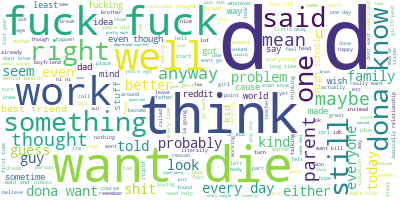

In [15]:
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

wordcloud.generate(all_text)

wordcloud.to_image()

**Conclusion:** Here, words like `fuck`, `work`, `think`, `want`, `die`, `shit`, `parent`, `mean`, `better`, `look` are present among many others.

### Non-Suicide Text <a class="anchor" id="ns_wc"></a>

For the second word cloud, we are going to use non-suicide tweets. This can indicate if there is a significant difference between the tweets with suicide class and those with non-suicide class.

In [16]:
non_suicide_text = ",".join(list(data[data['class'] == 'non-suicide'].text.values))

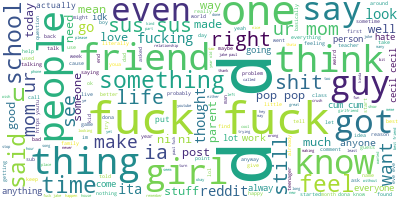

In [17]:
ns_wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

ns_wordcloud.generate(non_suicide_text)

ns_wordcloud.to_image()

**Conclusion:** Here, words like `people`, `think`, `fuck`, `girl`, `life`, `time`, `friend`, `reddit`, `school` are present among many others.

### Suicide Text <a class="anchor" id="s_wc"></a>

For the third word cloud, we are going to use suicide tweets.

In [18]:
suicide_text = ",".join(list(data[data['class'] == 'suicide'].text.values))

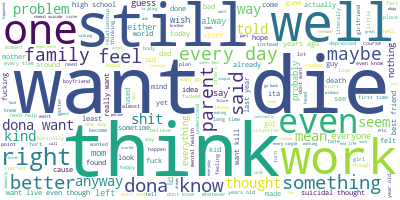

In [19]:
s_wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

s_wordcloud.generate(suicide_text)

s_wordcloud.to_image()

**Conclusion:** Here, words like `think`, `want`, `die`, `work`, `parent`, `family`, `still` are present among many others. Interestingly, the words are quite different as shown by the word clouds. This suggests there is some inheret difference between the suicide tweets and non-suicide tweets.


## Topic Modelling <a class="anchor" id="topic_modelling"></a>

> "Topic modeling is a machine learning technique that automatically analyzes text data to determine cluster words for a set of documents." ([source: monkey learn](https://monkeylearn.com/blog/introduction-to-topic-modeling/))

The idea behind Topic Modelling is to take each piece of text as a `document` and try to find what `topic` this document belongs to. This is an unsupervised learning technique. We do not know what the topics are called. All we are interested in is to see whether we can find a way to categorise these documents into an arbitrary number of topics. This number is usually `5` to `10` but for large corpuses, it can go as high as required.

### Procedure <a class="anchor" id="topic_modelling_procedure"></a>

The procedure of topic modelling is simply divided into some key steps.

- Tokenization or Making Words
- Stemming & Lemmatization (removing the word extensions to only keep the root word, `formally` and `formal` both become `formal`)
- Stopword Removal (words like `to`, `and` et al. are stop words and don't add any value to the text analysis)
- Create a Dictionary or Bag of Words (we create a tagged dictionary of all the words in all the documents)
- Map Corpus (we find the frequency of the words in this dictionary. For example, if `apple` has an ID of 1, and appears twice in a document, it becomes `(1,2)`)

### Latent Dirichlet allocation (LDA) <a class="anchor" id="lda"></a>

Most commonly, we use the `Latent Dirichlet allocation (LDA)` which is the method we are going to leverage as well. For LDA, we try to find the latent layer or the hidden layer to which the documents (text) belong to. For example, a book on birds and a book on reptiles belong to some logical topic. It may be `wildlife` or it may be `biology`. We don't know the label, but we know there is a connection. That is the latent layer.

The LDA process is elaborated below.

_Key Assumption: The key assumption of LDA is that "each document is generated from a set of topics, and each topic was picked from a certain set of words."_

The idea of LDA is to reverse engineer this process and find the topics from the words. This is done by the following algorithm.

- Assumption: There are n topics in the corpus.
- Distribute the n across the document m. 
- For each word w in m, assume the topic is wrong. That is, the word is misassigned.
- Use a probability model to assign the correct topic. This is based on how many topics are in m and how many times is w given to m.
 - For example, if apple is the misassigned topic, we will assign it the correct topic based on what topics are in the document and how many other topics are assigned to apple (assumption is that the others are correct).
- We repeat this algorithm over and over for all documents and words.

![1_VTHd8nB_PBsDtd2hd87ybg.png](attachment:1_VTHd8nB_PBsDtd2hd87ybg.png "Smoothed LDA from Wikipedia.")

_([source](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#/media/File:Smoothed_LDA.png))_

Above is the LDA model where,

- α is the topics-per-document
- β is the words-per-topic
- θ is the topic distribution for m
- φ is the word distribution for k
- z is the topic for word n in document m
- w is the word


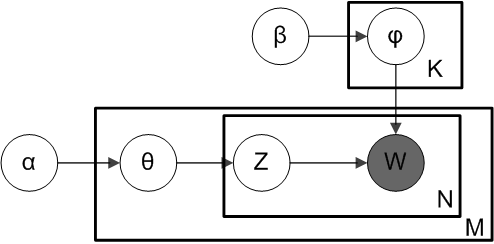

In [20]:
def make_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [21]:
def remove_stopwords(texts):
    return [[word for word in words if word not in stop_words] for words in texts]

In [22]:
words = data.text.values
words = list(make_words(words))

In [23]:
words = remove_stopwords(words)

In [24]:
id2word = corpora.Dictionary(words)

In [25]:
texts = words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:20])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [26]:
n = 6

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n)

In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"like" + 0.012*"feel" + 0.012*"im" + 0.010*"want" + 0.010*"life" + '
  '0.009*"even" + 0.008*"get" + 0.007*"dont" + 0.007*"know" + 0.007*"one"'),
 (1,
  '0.027*"ia" + 0.016*"like" + 0.010*"know" + 0.009*"dona" + 0.009*"get" + '
  '0.008*"people" + 0.008*"day" + 0.008*"want" + 0.007*"one" + 0.006*"life"'),
 (2,
  '0.008*"get" + 0.008*"like" + 0.007*"time" + 0.006*"one" + 0.006*"know" + '
  '0.006*"got" + 0.006*"people" + 0.005*"would" + 0.005*"school" + '
  '0.005*"want"'),
 (3,
  '0.026*"want" + 0.017*"fuck" + 0.013*"know" + 0.012*"die" + 0.012*"life" + '
  '0.010*"ia" + 0.009*"fucking" + 0.009*"feel" + 0.008*"like" + 0.007*"one"'),
 (4,
  '0.018*"like" + 0.015*"ia" + 0.013*"feel" + 0.010*"life" + 0.009*"want" + '
  '0.009*"know" + 0.009*"time" + 0.009*"never" + 0.008*"think" + '
  '0.008*"people"'),
 (5,
  '0.011*"know" + 0.009*"like" + 0.009*"life" + 0.008*"really" + '
  '0.008*"people" + 0.008*"want" + 0.008*"get" + 0.008*"would" + 0.008*"feel" '
  '+ 0.007*"one"')]


### Topic Interpretation <a class="anchor" id="topic_modelling_interpretation"></a>

We will now try to interpret the topics we've made. The above expressions show the word contributions to the topics. We have chosen to go with `6` topics but given the data is about a few things only, there may be some commonality and/or repetition.

In any case, below is a description and keyword for each topic.

- **Cursing/Frustration:** People who write similar tweets to this are clearly frustrated and boiling. They are angry and want to take it out with the language they use. This may be their breaking point.
- **Seeking Help:**: Words like get, want and help suggest that the people are trying to seek help.'
- **Hope (Unmet Hope):** The words suggest some hope which may or may not be coming to pass. Words like "one", "got", "day" and "life" appear which could be interpreted this way.
- **Students:** Students who are succumbing to the ever-increasing pressure of school--grades, relationships, friendships, coming of age, puberty, parental pressure, substance are some things that affect students and may push them.
- **Busy:** The word "time", "want" and "get" suggest that there is some conversation about not being able to make time for everything.
- **Unclear:** This topic does not offer much comprehensive information. We will call it Unclear or Miscellaneous.

In [30]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)]

In [29]:
topics = []
total = len(corpus)

for i in range(0, total):
    topics.append(get_max(lda_model[corpus[i]]))

## Making Features <a class="anchor" id="making_features"></a>

Apart from topic modelling, we can also find more features from the text. This process is called **Feature Generation**. The idea is to take the text and make numerical features out of it. Some of the features we have created are,

- topic: most probable topic
- text_length: the length of the text in characters
- word_count: the total number of words in text, counted by spaces

Other examples of this can be emoji counts, numbers and email, but all of these are currently not relevant or out of the scope of this project.

In [36]:
data['topic'] = topics

In [37]:
data['text_length'] = data.text.apply(len)

In [38]:
data['word_count'] = data.text.str.split().str.len()

## Modelling: Pre-Processing <a class="anchor" id="pre_processing"></a>

A machine learning model is still a mathematic algorithm. We cannot feed it a series of words. Computers talk in numbers and that is what we need. Therefore, we have to preprocess the text into numbers. For this, we use a `vectorizer`. A vectorizer converts text into vectors or matrices. This process usually involves `Stemming` and `Tokenizing` the words as well. So, we will conduct these processes again as part of our pipeline.

In [31]:
data.text[0]

'ex wife threatening suiciderecently left wife good cheated twice lied much decided refuse go back days ago began threatening suicide tirelessly spent paat days talking keeps hesitating wants believe come back know lot people threaten order get way happens really supposed handle death hands still love wife cannot deal getting cheated constantly feeling insecure worried today may day hope much happen'

In [32]:
# Missing Check

data['class'].isna().sum()

0

In [33]:
data.shape

(232044, 3)

### Valence Aware Dictionary and sEntiment Reasoner (VADER) <a class="anchor" id="vader"></a>

VADER is a pre-trained Sentiment Analysis model in Python. It is one of the most popular ones used today. It's a parsimonious rule based model first given by [Hutto and Gilbert](https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399) in 2014. The model originally supplemented the ANEW, LICW and the General Inquirer lexicons to tune the model. Below is the model construction from the original paper.

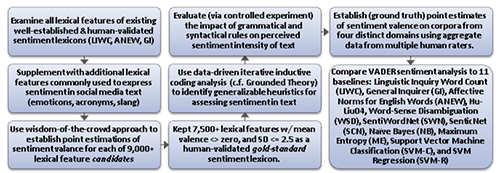

_([source]())_

The VADER model returns a `dict` with the `polarity_scores()` function. The dict has proportions named `pos`, `neu`, `neg` but it also returns a `compound` variable that is a score in the range of `[-1, 1]`. We are going to leverage this very score for our model feature augmentation.

In [34]:
vader = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return float(vader.polarity_scores(text)['compound'])

data['sentiment'] = data['text'].progress_apply(get_sentiment)

100%|█████████████████████████████████████████████████████████████████████████| 232044/232044 [10:03<00:00, 384.35it/s]


In [39]:
data.head()

,Unnamed: 0,text,class,sentiment,topic,text_length,word_count
0,2,ex wife threatening suiciderecently left wife ...,suicide,-0.9605,0,401,61
1,3,weird get affected compliments coming someone ...,non-suicide,0.5563,5,90,13
2,4,finally 2020 almost never hear 2020 bad year e...,non-suicide,0.2651,1,76,13
3,8,need helpjust help im crying hard,suicide,-0.2023,3,33,6
4,9,ia losthello name adam 16 ia struggling years ...,suicide,-0.9962,4,1538,234


### Term Frequency-Inverse Document Frequency (TF-IDF) <a class="anchor" id="tfidf"></a>

A note on `TF-IDF` that we have used as vectorizer procedure is important here. Term Frequency - Inverse Document Frequency or TF-IDF is a feature generation and information retrieval (IR) technique which can quantify how relevant a string or a bigram (collection of two words) is to the document. Ideally, when we vectorize it in this process, we are creating a measure of the most important strings from all of the possible string combinations. This creates sparse matrices. That is, matrices with zeros for each of the documents (tweets, in this case).

TF-IDF is the measure of relative frequency of the words. The process is breifly explained below.

#### Term Frequency (TF) <a class="anchor" id="tfidf_tf"></a>

The term frequency is simply the number of occurences of a word (term) versus the total occurrences of all words in the document. This is the TF.

${tf}_{i,j} = \tfrac{ {n_{i,j}} } { \sum_{k} {n_{i,j}} } $

#### Inverse Document Frequency (IDF) <a class="anchor" id="tfidf_idf"></a>

For the IDF, we calculate the `log` of number of documents by the number of documents that contain the word w. This tells us the weight of rare words in the document.

$ {idf (w) = log(\tfrac{N}{df_{t}} ) } $

#### TF-IDF <a class="anchor" id="tfidf_tfidf"></a>

The TF-IDF is the product of the above two. This gives us a measure of the word relevancy or importance.

$ {w}_{i,j} = \tfrac{ {n_{i,j}} } { \sum_{k} {n_{i,j}} } \cdot { log(\tfrac{N}{df_{t}} ) } $


#### TfidfVectorizer <a class="anchor" id="tfidf_vect"></a>

Instead of using TF-IDF explicitly, the `sklearn TfidfVectorizer` does all the work for us!


In [40]:
english_stemmer = Stemmer.Stemmer('en')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))
tfidf = StemmedTfidfVectorizer(min_df=1, stop_words='english', analyzer='word', ngram_range=(1,1))

In [41]:
X = tfidf.fit_transform(data.text.values)

### Adding Generated Features <a class="anchor" id="adding_generated_features"></a>

Now that we have the matrices, we add the information we extracted to the matrices. This ensures our analysis and topic modelling feeds into the model as well. This may be the reason it performs well, if it does. 

##### Topic

In [42]:
X = hstack((X, np.array(data['topic'])[:,None])).tocsr()

##### Text Length

In [43]:
X = hstack((X, np.array(data['text_length'])[:,None])).tocsr()

##### Word Count

In [44]:
X = hstack((X, np.array(data['word_count'])[:,None])).tocsr()

##### Sentiment (VADER)

In [45]:
X = hstack((X, np.array(data['sentiment'])[:,None])).tocsr()

#### Converting Y to Labels

In [46]:
y = data['class'].replace(['non-suicide', 'suicide'],[0, 1])

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

For the features we have just calculated, we can conduct EDA which is to say we will plot them and view them individually to see if there are certain patterns in them. Since most of the features are extracted, we will only use them as they are the only numerical features available.

- Topic
- Text Length
- Word Count
- Sentiment

### Topic <a class="anchor" id="eda_topic"></a>

While we've made LDA topics, it would be curious to see their distribution and if there is some sort of imbalance in the data when it comes to topics.

In [59]:
topic_summary = data.groupby('topic').agg('count').reset_index()
topic_summary = topic_summary[['topic', 'Unnamed: 0']]
topic_summary.rename(columns={'Unnamed: 0': 'count'}, inplace=True)

In [76]:
topic_summary['topic'] = topic_summary.topic.astype('str')

<AxesSubplot:xlabel='topic', ylabel='count'>

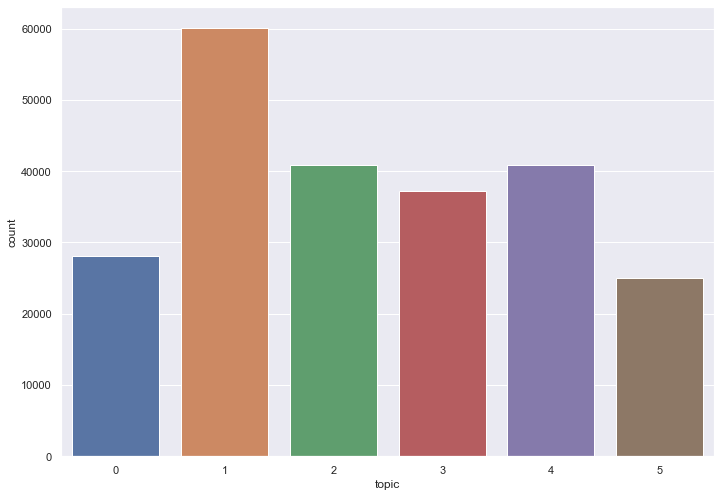

In [81]:
sns.barplot(x = 'topic', y = 'count', data = topic_summary, )

**Interpretation:** As we can see, topic 1 (Seeking Help) has the highest representation in the data, followed by topic 4 (Busy) and 2 (Hope - Unmet Hope). The lowest representation comes from topic 5 (Unclear). Overall, this tells us that out of the 6 topics that we made, the distribution is not normal or balanced. Also, since the least amount of representation is Unclear, we can say we have identified topics for most of the people involved. This is good because that means we are able to successfully understand the topics or contexts people have tweeted about. It is also interesting how **Seeking Help** is the most common topic.

### Text Length <a class="anchor" id="eda_text_length"></a>

The text length variable is a univariate variable since there is only the numeric length of text in characters. We will make a histogram for this variable and see if the text lengths are distributed normally.

<AxesSubplot:xlabel='text_length', ylabel='Count'>

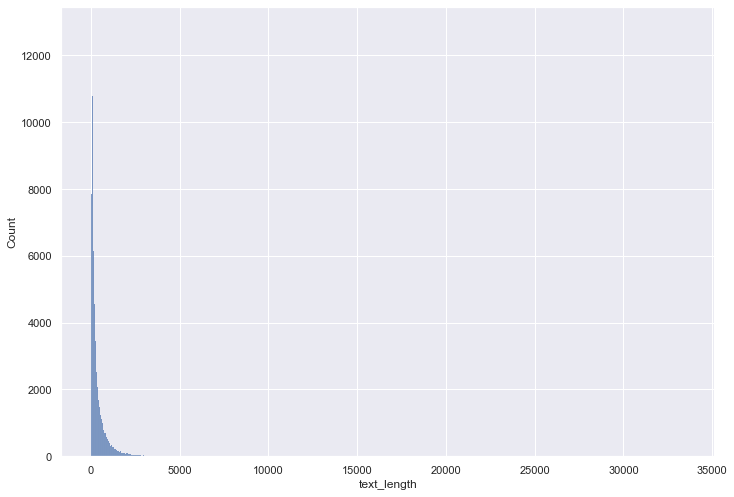

In [84]:
sns.histplot(data['text_length'])

**Interpretation:** From the histogram, we can see that the range seems to be too high. That suggests there are outliers, but we can also see that most of the text is short and it falls slowly towards longer ranges. This suggests the data is left-skewed, which is usual for online texts and is a bit obvious given the nature of social media.

<AxesSubplot:xlabel='text_length'>

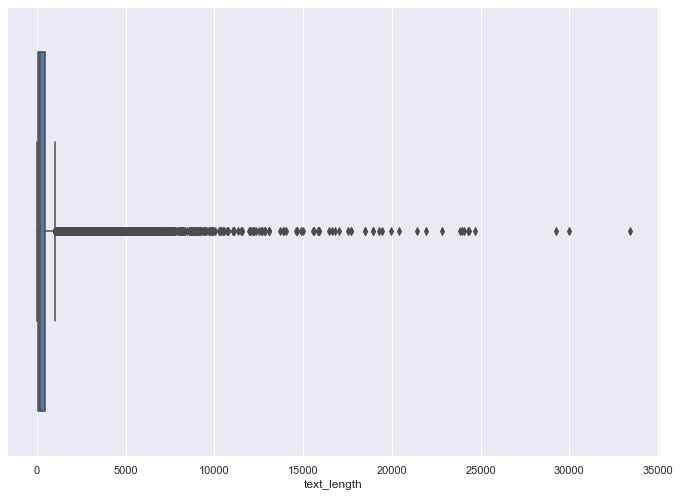

In [85]:
sns.boxplot(data['text_length'])

**Interpretation:** With the boxplot, we see a similar pattern. There are many outliers in the data that increase the range of the data, which suggests that the text is quite varied in length.

In [89]:
data.text_length.describe()

count    232044.000000
mean        403.127446
std         668.014880
min           0.000000
25%          86.000000
50%         189.000000
75%         467.000000
max       33441.000000
Name: text_length, dtype: float64

**Interpretation:** As we agreed above with the plots, the summary says the average length is 403 charaacters while the median length is 189 characters. Also, the maximum is 33441 which suggests the outlier situation. From the 75th quantile to the 100% quantile, the leap is quite long. (467 -> 33441)

### Word Count <a class="anchor" id="eda_word_count"></a>

Similar to text length, we will look at the word count as a histogram, as a boxplot and as a numeric summary to understand the distribution and if there is any skewness.

<AxesSubplot:xlabel='word_count', ylabel='Count'>

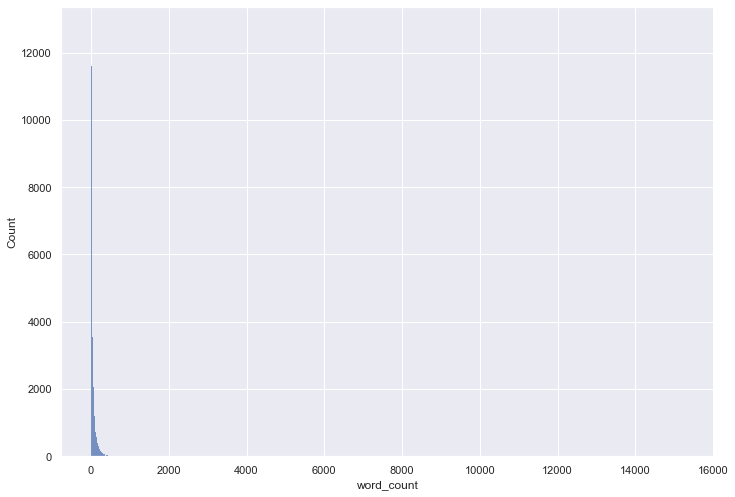

In [90]:
sns.histplot(data['word_count'])

**Interpretation:** Just as in the case with `text_length`, the `word_count` variable is distributed with a left-skewness. That is not a surprise since there is bound to be some correlation between the two.

<AxesSubplot:xlabel='word_count'>

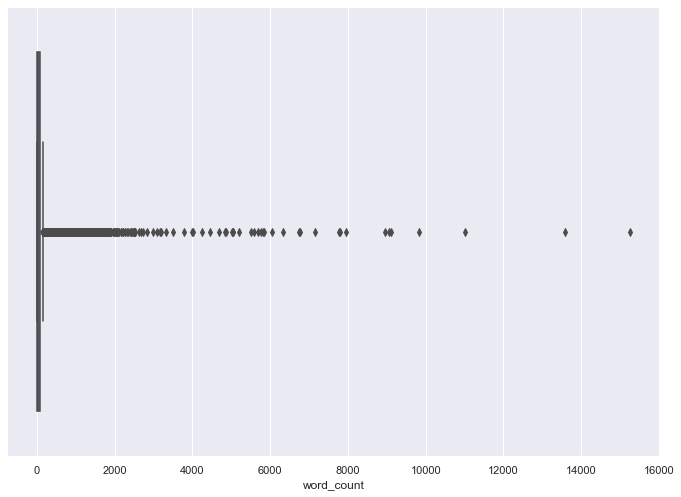

In [91]:
sns.boxplot(data['word_count'])

**Interpretation:** There are outliers but the major ranges are concentrated towards the left, further cementing the left-skewness of the data. The findings are in agreement with text length as well as the general nature of social media.

In [92]:
data.word_count.describe()

count    232044.000000
mean         64.608415
std         133.063174
min           0.000000
25%          14.000000
50%          30.000000
75%          74.000000
max       15266.000000
Name: word_count, dtype: float64

**Interpretation:** If we notice, there is a fantastic leap between the 75th quantile and the 100th quantile. 74 to 15266. This suggests that most of the data has less than 74 words. It is only 25% of the data that goes beyond it till 15266.

### Sentiment Score <a class="anchor" id="eda_sentiment"></a>

The sentiment score is interesting since it is a numeric variable but we will have to create a summary for it to understand the sentiments and their distributions. Overall, we can also view it as a fully numeric variable so we will also create univariate plots and we will also look at it as a bivariate data point.

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

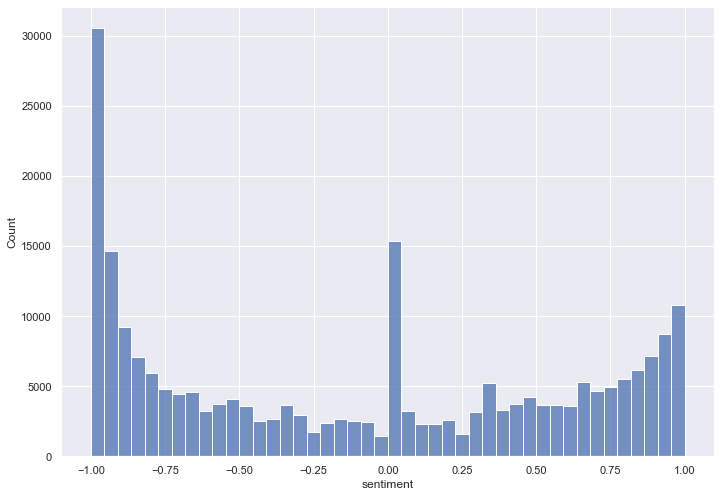

In [93]:
sns.histplot(data.sentiment)

**Interpretation:** Naturally, the data has a long distribution towards `-1` which is fully negative. The lowest peak is at `+1` but there are a lot of neutral `0` text entries as well.

<AxesSubplot:xlabel='sentiment'>

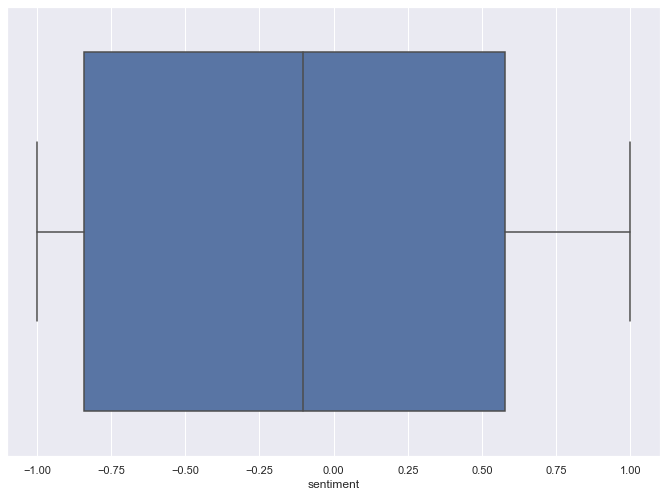

In [94]:
sns.boxplot(data.sentiment)

**Interpretation:** The median sentiments score is slightly left of 0, which suggests that there is an overall negative connotation to the data. This makes sense given the nature and context of the analysis. In fact, it is fortunate that there are any neutral and positive connotations at all.

In [95]:
data.sentiment.describe()

count    232044.000000
mean         -0.109911
std           0.702028
min          -1.000000
25%          -0.842500
50%          -0.102700
75%           0.577300
max           1.000000
Name: sentiment, dtype: float64

In [135]:
sentiment_summary = pd.DataFrame(data['sentiment'])

In [136]:
sentiment_summary.loc[sentiment_summary.sentiment == 0, 'connotation'] = 'neutral'
sentiment_summary.loc[sentiment_summary.sentiment < 0, 'connotation'] = 'negative'
sentiment_summary.loc[sentiment_summary.sentiment > 0, 'connotation'] = 'positive'

In [137]:
sentiment_summary = sentiment_summary.groupby('connotation').agg(['count', 'mean']).reset_index().droplevel(level=0, axis=1)
sentiment_summary.reset_index()
columns = ['connotation', 'count', 'mean']

In [138]:
sentiment_summary.rename( columns={i:j for i,j in zip(sentiment_summary.columns.tolist(),columns)}, inplace=True)

In [139]:
sentiment_summary

,connotation,count,mean
0,negative,120834,-0.714361
1,neutral,13886,0.000000
2,positive,97324,0.624871


<AxesSubplot:xlabel='connotation', ylabel='count'>

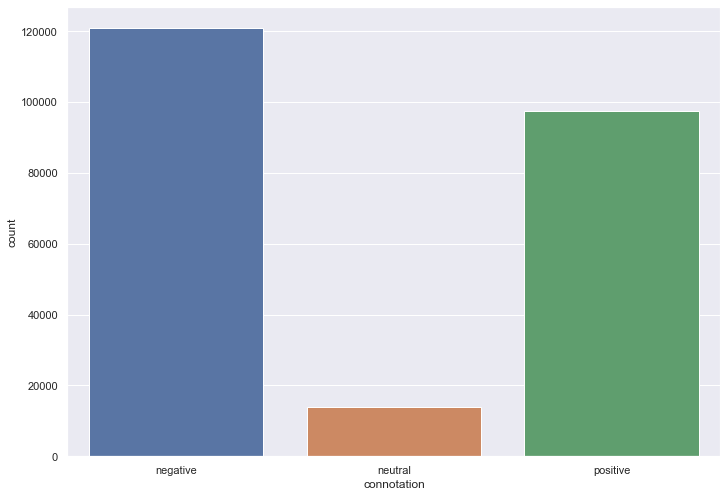

In [140]:
sns.barplot(x='connotation', y='count', data = sentiment_summary)

**Interpretation**: As we can see, the maximum number of text entries are negative, some are positive and the lowest are neutral. In terms of counts, the counts are 1,20,834 for negative, 97,325 for positive and 13,886 for neutral.

In [143]:
sentiment_summary['abs_mean'] = np.abs(sentiment_summary['mean'])

<AxesSubplot:xlabel='connotation', ylabel='abs_mean'>

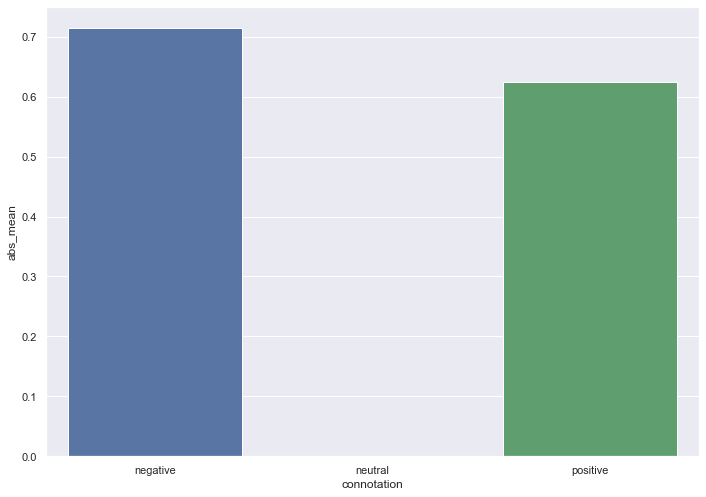

In [145]:
sns.barplot(x='connotation', y='abs_mean', data = sentiment_summary)

**Interpretation**: For this plot, we are looking at the absolute value of the mean for all three labels. For neutral, the mean will be 0 of course. The goal is to check the valence of the emotion or sentiment. It is an analysis of "how much?". In general, people who have negative tweets are more negative than those who have positive tweets are positive. This indicates that the negative connotation is higher in a magnitudal or valence sense as well.

This concludes our EDA, we will now proceed to conducting a clustering exercise to see if there is a natural two class division in the data. For this, we will assume it to be unlabelled data.

## Clustering <a class="anchor" id="clustering"></a>

Clustering is the process of taking unsupervised or unlabelled data and finding common properties in them. The idea is to split the data into groups or clusters. Here, we will conduct clustering in two ways. The first will be with the high dimensional data. The second will be by doing Principal Component Analysis (PCA) and reducing this dimensionality.

### Clustering (No PCA) <a class="anchor" id="clustering_no_pca"></a>

For this, we will directly cluster the data into two segments.

In [150]:
kmeans_vanilla = KMeans(n_clusters=2, random_state=42).fit(X)

In [186]:
kmeans_vanilla_labels = kmeans_vanilla.labels_

**Limitation:** The sparse matrices are too large to be plot into a scatter graph. The required Memory exceeds what we have at hand currently. In any case, we have displayed the data points as a table.

In [197]:
cluster_vanilla = pd.DataFrame(kmeans_vanilla_labels)
cluster_vanilla.columns = ['cluster']
cluster_vanilla['cluster'] = cluster_vanilla.cluster.astype('category')

In [206]:
cluster_vanilla = pd.DataFrame(cluster_vanilla.cluster.value_counts()).reset_index()
cluster_vanilla.columns = ['cluster', 'count']

<AxesSubplot:xlabel='cluster', ylabel='count'>

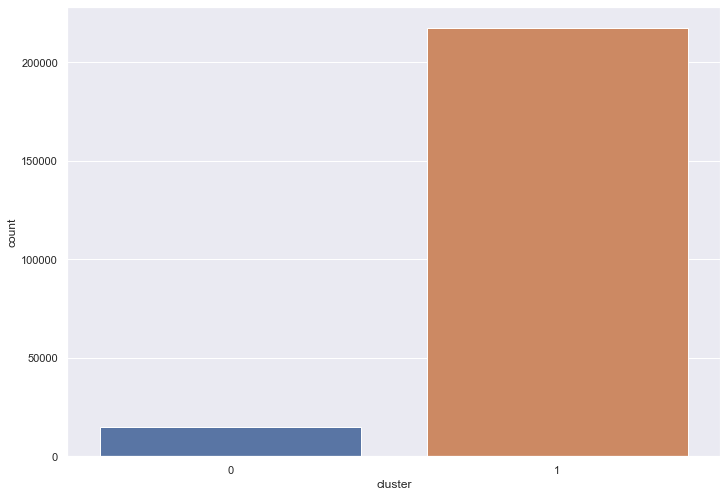

In [210]:
sns.barplot(x = 'cluster', y = 'count', data=cluster_vanilla)

**Interpretation:** When we cluster without doing a PCA, we end up with really disproportionate clusters. This seems to suggest that the data is not very well divided into two categories naturally.

### Clustering (Dimensionality Reduction) <a class="anchor" id="clustering_pca"></a>

For this, we will first conduct the PCA process and then cluster the data into two segments.

**Note:** Since our matrix is sparse, we are going to use the TruncatedSVD for dimensionality reduction and not PCA.

In [235]:
tsvd = TruncatedSVD(n_components = 2)

In [242]:
svd_i = []
svd_variance = []

for i in tqdm(range(0,20)):
    svd_i.append(i)
    tsvd = TruncatedSVD(n_components = i)
    tsvd.fit(X)
    svd_variance.append(tsvd.explained_variance_ratio_.sum())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.57s/it]


<AxesSubplot:>

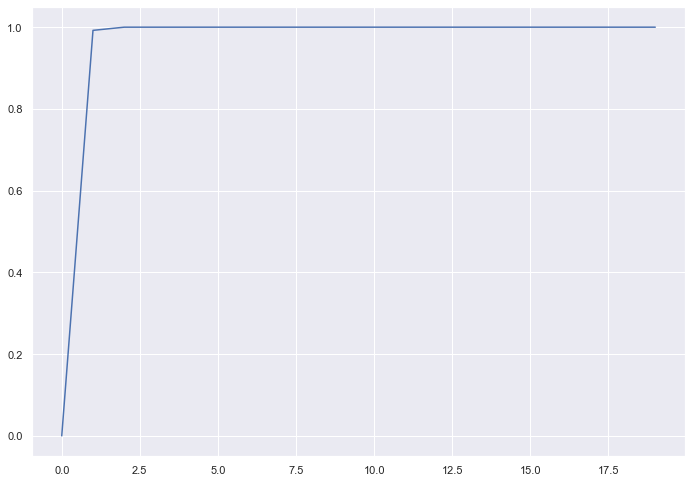

In [246]:
sns.lineplot(x=svd_i, y=svd_variance)

In [251]:
dict(zip(svd_i, svd_variance))

{0: 0.0,
 1: 0.992208490945764,
 2: 0.9999897536105768,
 3: 0.999996870858547,
 4: 0.9999979138921405,
 5: 0.9999979380425065,
 6: 0.9999979567533515,
 7: 0.9999979663299866,
 8: 0.999997975511672,
 9: 0.9999979841488507,
 10: 0.9999979921287998,
 11: 0.999997999673637,
 12: 0.9999980060805997,
 13: 0.9999980123607957,
 14: 0.9999980183147724,
 15: 0.9999980242860551,
 16: 0.9999980297770956,
 17: 0.9999980346470876,
 18: 0.9999980399364695,
 19: 0.9999980447673438}

**Interpretation:** The plot suggests that even one component almost fully explains the varaiance in X.

In [247]:
X_tsvd = TruncatedSVD(n_components = 1).fit_transform(X)

In [252]:
kmeans_reduced = KMeans(n_clusters=2, random_state=42).fit(X_tsvd)

In [253]:
kmeans_reduced_labels = kmeans_reduced.labels_

**Limitation:** Again, the sparse matrices are too large to be plot into a graph. The required Memory exceeds what we have at hand currently. In any case, we have displayed the data points as a table.

In [254]:
cluster_reduced = pd.DataFrame(kmeans_reduced_labels)
cluster_reduced.columns = ['cluster']
cluster_reduced['cluster'] = cluster_reduced.cluster.astype('category')

In [255]:
cluster_reduced = pd.DataFrame(cluster_reduced.cluster.value_counts()).reset_index()
cluster_reduced.columns = ['cluster', 'count']

<AxesSubplot:xlabel='cluster', ylabel='count'>

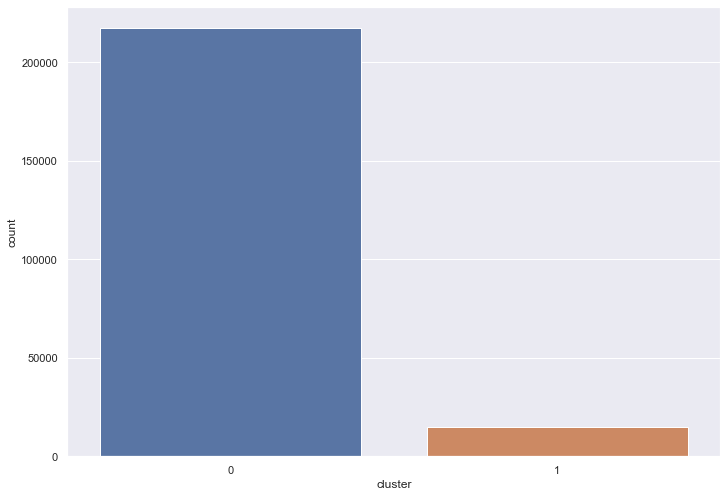

In [256]:
sns.barplot(x = 'cluster', y = 'count', data=cluster_reduced)

**Interpretation:** The 0 and 1 are not relevant. Essentially, as per the counts, it is evident that the data can be clustered into two very uneven groups if taken as unlabelled. But without being able to look at the plot, we **cannot** say for certain if the clusters are not divided. The memory issue limitation (we need about 236 GB of RAM to make the sparse matrix into a matrix) makes that impossible.

### Clustering (Comparison) <a class="anchor" id="clustering_original"></a>

One little attempt at this can be to try and plot the original classes.

<AxesSubplot:xlabel='label', ylabel='count'>

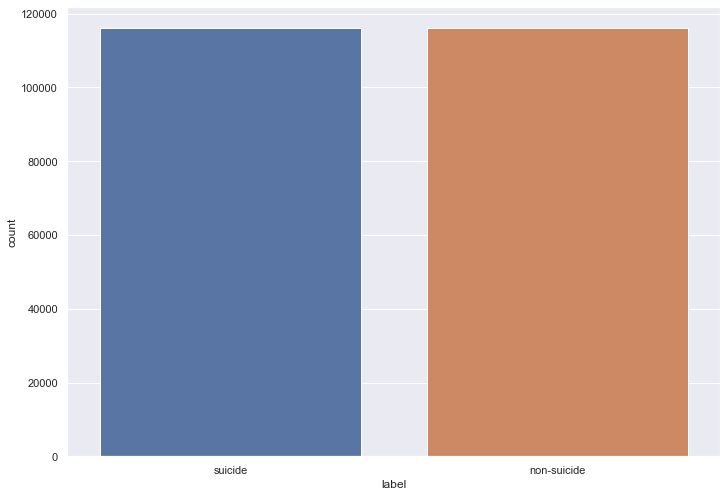

In [265]:
class_data = pd.DataFrame(data['class'].value_counts()).reset_index()
class_data.columns = ['label', 'count']
sns.barplot(x='label', y='count', data=class_data)

**Interpretation:** Interestingly, the original class data is balanced. The clustering does not indicate much confidence over whether the data is truly dividable but we tread on and we will try to make models to try and discriminate the data based on our features.

## Making Models <a class="anchor" id="modelling"></a>

To make the model, we are going to split the data into a `75`:`25`::`train`:`test` ratio. Then, we will use the following models,

- Logistic Regression Model
- Stochastic Gradient Descent Classifier
- Perceptron

to separate between the two categories (now encoded as labels). Hence, the model returns a 1 or a 0. That tells us what the response is. The training process is straightforward. Most of the heavy lifting is done as part of Feature Generation, Information Retrieval and Pre-Processing.

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Logistic Regression Model <a class="anchor" id="lm"></a>

A logistic regression model works to calculate the log-odds. It is essentally a linear model that finds odds/probabilities of something being a certain label.

In [281]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [282]:
lr

LogisticRegression(random_state=42)

In [283]:
lr_train = round(lr.score(X_train, y_train)*100, 2)
print(f'Logistic Regression Train Accuracy: {lr_train}')

Logistic Regression Train Accuracy: 88.36


In [284]:
lr_test = round(lr.score(X_test, y_test)*100, 2)
print(f'Logistic Regression Test Accuracy: {lr_test}')

Logistic Regression Test Accuracy: 88.41


## SGD Classifier <a class="anchor" id="sgd"></a>

The SGD Classifier performs linear learning using models like SVM, LM et al. but adds the Stochastic Gradient Descent to their process. This works with data in sparse arrays of floating point values for the features. That is why this model is chosen -- our data is sparse.

In [285]:
sgd = SGDClassifier(random_state = 42)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [286]:
sgd

SGDClassifier(random_state=42)

In [287]:
sgd_train = round(sgd.score(X_train, y_train)*100, 2)
print(f'Stochastic Gradient Descent Classifier Train Accuracy: {sgd_train}')

Stochastic Gradient Descent Classifier Train Accuracy: 69.03


In [288]:
sgd_test = round(sgd.score(X_test, y_test)*100, 2)
print(f'Stochastic Gradient Descent Classifier Test Accuracy: {sgd_test}')

Stochastic Gradient Descent Classifier Test Accuracy: 68.8


## Perceptron <a class="anchor" id="perceptron"></a>

This is a simple linear perceptron classifier. The idea to use this is because if it attains the same accuracy as the others, we might be able to conclude this as a baseline model.

In [289]:
p = Perceptron(random_state = 42)
p.fit(X_train, y_train)

Perceptron(random_state=42)

In [290]:
p

Perceptron(random_state=42)

In [291]:
p_train = round(p.score(X_train, y_train)*100, 2)
print(f'Perceptron Classifier Train Accuracy: {p_train}')

Perceptron Classifier Train Accuracy: 63.75


In [292]:
p_test = round(p.score(X_test, y_test)*100, 2)
print(f'Perceptron Classifier Test Accuracy: {p_test}')

Perceptron Classifier Test Accuracy: 63.77


### Model Evaluation <a class="anchor" id="model_evaluation"></a>

To evaluate the model, we are only interested in the accuracy at the time. If we look at the table, we can see that out of all three, the Logistic Regression performs the best, followed by the SGD. The Perceptron being a simpler model overfits in training and out of the three test accuracies, performs the worst.

The SGD is essentially a linear SVM which may be too complex a model for this data. Our matrix is sparse, however, which makes it ideal for the SGD. Perhaps, with some hyperparameter tuning the SGD may outperform the logistic regression, but for now, the LR is the most ideal model.

In [293]:
# Combining

models = ['LR', 'SGD', 'Perceptron']
trains = [lr_train, sgd_train, p_train]
tests = [lr_test, sgd_test, p_test]

pd.DataFrame(list(zip(models, trains, tests)),
              columns=['model','train_accuracy', 'test_accuracy'])

,model,train_accuracy,test_accuracy
0,LR,88.36,88.41
1,SGD,69.03,68.80
2,Perceptron,63.75,63.77


## Conclusion <a class="anchor" id="conclusion"></a>

As a summary, we first created word clouds for all words, suicide tweets and non-suicide tweets. This indicated whether there is a difference in behaviour, verbage etc for these categories. Then, we conducted topic modelling on the text and made and inferred six topics. This data was augmented along with other data into the dataset. Then, we applied sentiment analysis using VADER and used that score as a column in the data. Finally, we conducted TF-IDF and got the final sparse matrix. All of this was combined into a final dataset to make it ready for the model. Before modelling, we conducted EDA and viewed the variables. lso, we clustered the data with and without dimensionality reduction then compared it with the original labels. Finally, we used three different models, after splitting the data, and checked which model generalises the best. It seems a Logistic Regression model outperforms the other two options.

Does this solve the problem of suicides? Of course not. But it provides a glimpse at the possibility. It provides us a step to move in the right direction. Today, we create data faster than ever before. In fact, in one day we create data that was not created in thousands of years. This data has a potential to make large changes and improve systems, of course, but it also has the potential to save lives. This project is but a humble attempt to show the same. Social Media platforms, for example, can attach check-ins when their models detect some behaviour that seems unsafe or hints towards suicidal ideation and tendencies.

In any case, this concludes the report.